In [23]:
# %%writefile run_em1d_multiprocessing.py
try:
    from multiprocessing import Pool
except ImportError:
    PARALLEL = False
else:
    PARALLEL = True
    
from SimPEG import Mesh, Maps, Utils, Survey, Problem, Props
from simpegem1d import *
from scipy.constants import mu_0
import numpy as np
from multiprocessing import Pool   
import multiprocessing
import scipy.sparse as sp
# from schwimmbad import MPIPool as Pool

import time 

def set_mesh_1d():        
    cs = 10.
    nearthick = np.logspace(-1, 1, 3)
    linthick = np.ones(15)*cs
    deepthick = np.logspace(1, 2, 3)
    hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
    return Mesh.TensorMesh([hx], [0.])

def run_simulation_FD(args):
    """
        rxLoc, SrcLoc, mesh_1d, offset, frequency,
        field_type = 'secondary',
        rxType = 'Hz',
        srcType = 'VMD'

    """    
    sigma, jacSwitch = args
    mesh_1d = set_mesh_1d()
    # Todo: require input args
#     rxLoc, SrcLoc, mesh_1d, offset, frequency, field_type, rxType, srcType = args            
    FDsurvey = EM1DSurveyFD()
    FDsurvey.rxLoc = np.array([0., 0., 100.+30.])
    FDsurvey.srcLoc = np.array([0., 0., 100.+30.])
    FDsurvey.fieldtype = 'secondary'
    FDsurvey.rxType = 'Hz'
    FDsurvey.srcType = 'VMD'
    FDsurvey.offset = np.r_[8., 8., 8.]        
    nlay = depth.size
    topo = np.r_[0., 0., 100.]
    FDsurvey.depth = depth
    FDsurvey.topo = topo
    FDsurvey.LocSigZ = LocSigZ
    FDsurvey.frequency = np.r_[900., 7200., 56000]
    FDsurvey.Nfreq = FDsurvey.frequency.size
    FDsurvey.Setup1Dsystem()
    FDsurvey.SetOffset()
    imap = Maps.IdentityMap(mesh_1d)
    blk_ind = (-50>LocSigZ) & (-100<LocSigZ)

    prob = EM1D(
        mesh_1d, sigmaMap=imap, filter_type='key_101',
        jacSwitch=jacSwitch
    )
    if prob.ispaired:
        prob.unpair()
    if FDsurvey.ispaired:
        FDsurvey.unpair()
    prob.pair(FDsurvey)    
    if jacSwitch:
        u, dudsig = prob.fields(sigma)
        drespdsig = FDsurvey.projectFields(dudsig)
        return drespdsig
    else:
        u = prob.fields(sigma)
        resp = FDsurvey.projectFields(u)                
        return resp

class GlobalEM1DProblem(Problem.BaseProblem):
    """
        The GlobalProblem allows you to run a whole bunch of SubProblems,
        potentially in parallel, potentially of different meshes.
        This is handy for working with lots of sources,
    """
    sigma, sigmaMap, sigmaDeriv = Props.Invertible(
        "Electrical conductivity (S/m)"
    )    
    
    _Jmatrix = None
    n_cpu = None
    n_sounding = None    
    n_layer = None
    
    def __init__(self, mesh, **kwargs):
        Utils.setKwargs(self, **kwargs)
        if self.n_cpu is None:
            self.n_cpu = multiprocessing.cpu_count()
        self.sigmaMap = Maps.IdentityMap(mesh)
        # temporary
        self.n_sounding = mesh.nCx
        self.n_layer = mesh.nCy
        
    def forward(self, m, f=None):          
        self.model = m
        pool = Pool(self.n_cpu)
        Sigma = self.sigma.reshape((self.n_layer, self.n_sounding), order="F")
        if PARALLEL:
            result = pool.map(run_simulation_FD, [(Sigma[:,i], False) for i in range(self.n_sounding)])
            pool.close()
            pool.join()
        else:
            result = [run_simulation_FD((Sigma[:,i], False)) for i in range(self.n_sounding)]
        return np.hstack(result)
    
    def getJ(self, m):
        if self._Jmatrix is not None:
            return self._Jmatrix     
        self.model = m
        pool = Pool(self.n_cpu)
        Sigma = self.sigma.reshape((self.n_layer, self.n_sounding), order="F")
        # _Jmatrix is sparse matrix
        if PARALLEL:
#             self._Jmatrix = sp.block_diag(
#                 pool.map(run_simulation_FD, [(Sigma[:,i], True) for i in range(self.n_sounding)])
#             ).tocsr()
            # Possibility for parallel Jvec and Jtvec
            self._Jmatrix = pool.map(run_simulation_FD, [(Sigma[:,i], True) for i in range(self.n_sounding)])            
            pool.close()
            pool.join()                    
            
        else:
            self._Jmatrix = sp.block_diag(
                [run_simulation_FD((Sigma[:,i], True)) for i in range(self.n_sounding)]
            ).tocsr()            
        return self._Jmatrix
    
    def Jvec(self, m, v, f=None):
        J = self.getJ(m)
        if PARALLEL:
            V = v.reshape((self.n_sounding, self.n_layer))        

            pool = Pool(self.n_cpu)

            Jv = np.hstack(
                pool.map(dot, [(J[i], V[i, :]) for i in range(self.n_sounding)])
            )
            pool.close()
            pool.join()                
        else:
            return J*v                    
        return Jv

    def Jtvec(self, m, v, f=None):
        J = self.getJ(m)
        if PARALLEL:
            V = v.reshape((self.n_sounding, 6))

            pool = Pool(self.n_cpu)

            Jtv = np.hstack(
                pool.map(dot, [(J[i].T, V[i, :]) for i in range(self.n_sounding)])     
            )
            pool.close()
            pool.join()                
        else:
            return J.T*v
        return Jtv


# class GlobalEM1DSurveyFD(Survey.BaseSurvey):
    
#     rxlocs = None
#     srclocs = None
#     frequency = None
    
#     @Utils.count
#     @Utils.requires('prob')
#     def dpred(self, m=None, f=None):
#         """dpred(m, f=None)

#             Create the projected data from a model.
#             The fields, f, (if provided) will be used for the predicted data
#             instead of recalculating the fields (which may be expensive!).

#             .. math::

#                 d_\\text{pred} = P(f(m))

#             Where P is a projection of the fields onto the data space.
#         """
#         return self.prob.forward(m)
    
#     @property
#     def nD(self):
#         return self.prob.G.shape[0]   
    
#     def read_xyz_data(self, fname):
        

In [73]:
from simpegem1d.EM1DAnal import SkinDepth

In [200]:
def get_vertical_discretization(
    frequency, sigma_background=0.01, factor_fmin=4, facter_fmax=1., n_layer=19,
    hz_min=None, z_max=None
):        
    if hz_min is None:
        hz_min = SkinDepth(frequency.max(), sigma_background) / factor_fmin
    if z_max is None:
        z_max = SkinDepth(frequency.min(), sigma_background) * facter_fmax
    i = 4
    hz = np.logspace(np.log10(hz_min), np.log10(hz_min*i), n_layer)
    z_sum = hz.sum()        
    while z_sum<z_max:
        i+=1        
        hz = np.logspace(np.log10(hz_min), np.log10(hz_min*i), n_layer)
        z_sum = hz.sum()            
    print (z_max)    
    return hz

def set_mesh_1d(hz):        
    return Mesh.TensorMesh([hz], x0=[0])

#     cs = 10.
#     nearthick = np.logspace(-1, 1, 3)
#     linthick = np.ones(15)*cs
#     deepthick = np.logspace(1, 2, 3)
#     hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
#     return Mesh.TensorMesh([hx], [0.])

In [204]:
hz = get_vertical_discretization(frequency)

167.7640403482901


In [205]:
mesh_1d = set_mesh_1d(hz)

In [206]:
mesh_1d.vectorNx

array([  0.        ,   5.31699347,  11.05966405,  17.26209133,
        23.96108332,  31.19639487,  39.01096356,  47.45116459,
        56.5670859 ,  66.4128255 ,  77.04681243,  88.53215359,
       100.93700816, 114.33499214, 128.80561523, 144.43475262,
       161.31515467, 179.5469973 , 199.23847649, 220.50645037])

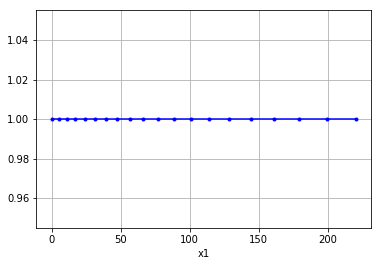

In [207]:
mesh_1d.plotGrid()

In [208]:
print (mesh_1d)

  ---- 1-D TensorMesh ----  
   x0: 0.00
  nCx: 19
   hx: 5.32,  5.74,  6.20,  6.70,  7.24,  7.81,  8.44,  9.12,  9.85,  10.63,  11.49,  12.40,  13.40,  14.47,  15.63,  16.88,  18.23,  19.69,  21.27,


In [209]:
# hz_min = 5.
# n_layer = 5
# hz = np.logspace(np.log10(hz_min), np.log10(hz_min*2), n_layer)
# hz.sum()

In [210]:
frequency = np.r_[900, 7200, 56000]

In [214]:
set_mesh_1d(frequency)

In [24]:
# %%time
# from SimPEG import Mesh
# import numpy as np
# n = [4, 40, 400]
# t = []
# for n_sounding in n:
# # n_sounding = 4
#     start = time.time()
#     n_layer = 22
#     mesh = Mesh.TensorMesh([n_sounding, n_layer])
#     m = np.ones(mesh.nC)
#     prob = GlobalEM1DProblem(mesh, n_cpu=3)
#     pred = prob.forward(m)
#     J = prob.getJ(m)
#     end = time.time()
#     t.append(end-start)

In [25]:
from simpegem1d import EM1DAnal

In [20]:
print (EM1DAnal.SkinDepth(1e5, 1e-2)/4.)

3.978873577297384


In [21]:
print (EM1DAnal.SkinDepth(900, 1e-2))

167.7640403482901


In [19]:
EM1DAnal.DiffusionDistnace(2e-6, 1e-2)/4.

4.460310290381927

In [22]:
EM1DAnal.DiffusionDistnace(1e-2, 1e-2)

1261.56626101008

In [8]:
np.r_[0., np.logspace(np.log10(5.), np.log10(500), 30)]

array([  0.        ,   5.        ,   5.86051149,   6.86911898,
         8.05131014,   9.43695911,  11.06108146,  12.96471899,
        15.19597691,  17.81123945,  20.87659468,  24.46950459,
        28.68076255,  33.61678768,  39.40231408,  46.18354286,
        54.13183669,  63.44805016,  74.36760536,  87.16644111,
       102.16798589, 119.751331  , 140.3608102 , 164.51722812,
       192.83102106, 226.01768282, 264.91584531, 310.50847095,
       363.9476922 , 426.58392621, 500.        ])

In [85]:
np.r_[5, 5.4, 5.8, 6.3, 6.7, 7.3, 7.8, 8.4, 9.1, 9.8, 10.6, 11.4, 12.3, 13.2, 14.3, 15.4, 16.6, 17.9, 19.3, 20.8, 22.4, 24.1, 26, 28, 30.2, 32.5, 35.1, 37.8, 40.7]

array([ 5. ,  5.4,  5.8,  6.3,  6.7,  7.3,  7.8,  8.4,  9.1,  9.8, 10.6,
       11.4, 12.3, 13.2, 14.3, 15.4, 16.6, 17.9, 19.3, 20.8, 22.4, 24.1,
       26. , 28. , 30.2, 32.5, 35.1, 37.8, 40.7])

In [89]:
np.logspace(np.log10(5), np.log10(40.7), 30)

array([ 5.        ,  5.37490566,  5.77792217,  6.21115731,  6.67687692,
        7.17751671,  7.71569503,  8.29422658,  8.91613708,  9.58467913,
       10.30334922, 11.075906  , 11.90638997, 12.79914457, 13.75883891,
       14.79049223, 15.89950008, 17.09166259, 18.37321479, 19.75085923,
       21.23180101, 22.82378548, 24.53513875, 26.37481123, 28.35242443,
       30.4783213 , 32.76362033, 35.22027366, 37.86112965, 40.7       ])

In [ ]:
n_sounding = 100000
start = time.time()
n_layer = 22
mesh = Mesh.TensorMesh([n_sounding, n_layer])
m = np.ones(mesh.nC)
prob = GlobalEM1DProblem(mesh, sigmaMap=Maps.IdentityMap(mesh))
pred = prob.forward(m)
J = prob.getJ(m)
Jtv = prob.Jtvec(m, np.ones(int(6*n_sounding)))
Jv = prob.Jvec(m, m)
end = time.time()
print(end-start)

In [36]:
Jv.shape

(60,)

In [37]:
Jtv.shape

(220,)

In [38]:
prob.n_cpu

12

In [4]:
# def run_simulation(
#     rxLoc, SrcLoc, mesh_1d, offset, frequency,
#     field_type = 'secondary',
#     rxType = 'Hz',
#     srcType = 'VMD'
# ):
#     FDsurvey = EM1DSurveyFD()
#     depth = -mesh1D.gridN[:-1]
#     LocSigZ = -mesh1D.gridCC
#     nlay = depth.size
#     topo = np.r_[0., 0., 100.]
#     FDsurvey.depth = depth
#     FDsurvey.topo = topo
#     FDsurvey.LocSigZ = LocSigZ
#     FDsurvey.Nfreq = FDsurvey.frequency.size
#     FDsurvey.Setup1Dsystem()
#     FDsurvey.SetOffset()
#     sig_half = 1e-4
#     sig_blk = 1e-2
#     chi_half = 0.
#     expmap = Maps.ExpMap(mesh1D)
#     sig  = np.ones(nlay)*sig_half
#     blk_ind = (-50>LocSigZ) & (-100<LocSigZ)
#     sig[blk_ind] = sig_blk
#     m_true = np.log(sig)

#     WT0, WT1, YBASE = DigFilter.LoadWeights()
#     prob = EM1D(
#         mesh1D, sigmaMap=expmap, filter_type='key_101',
#         jacSwitch=True,
#         chi= np.zeros(FDsurvey.nlay)
#     )
#     if prob.ispaired:
#         prob.unpair()
#     if FDsurvey.ispaired:
#         FDsurvey.unpair()
#     prob.pair(FDsurvey)    
#     u, dudsig = prob.fields(m_true)
#     resp = FDsurvey.projectFields(u)
#     drespdsig = FDsurvey.projectFields(dudsig)
#     return resp, drespdsig
# !python run_em1d_multiprocessing.py